In [8]:
conda install gsw

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - gsw


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gsw-3.6.20                 |  py312h4f23490_0         2.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.0 MB

The following NEW packages will be INSTALLED:

  gsw                conda-forge/linux-64::gsw-3.6.20-py312h4f23490_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transactio

In [7]:
# conda install -c conda-forge argopy

SyntaxError: invalid syntax (2438863892.py, line 2)

In [60]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with useful pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps

# Make a fresh start
import argopy
# argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

import gsw


import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean as cmo
import xarray as xr
import cartopy.crs as ccrs
import warnings
import cmocean

xr.set_options(display_expand_attrs = False)

# Subset Hurricane Track Data

In [7]:
hurricane_tracks.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=174)

In [5]:
hurricane_tracks = pd.read_csv("/home/jovyan/shared-public/OHW25/ArBu_proj_shared/ibtracs/ibtracs.ALL.list.v04r01.csv")

/tmp/ipykernel_284/278968951.py:1: DtypeWarning: Columns (1,2,8,9,14,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  hurricane_tracks = pd.read_csv("/home/jovyan/shared-public/OHW25/ArBu_proj_shared/ibtracs/ibtracs.ALL.list.v04r01.csv")


In [19]:
# time = hurricane_tracks['ISO_TIME']
# time
# # construct Boolean mask
mask = hurricane_tracks['ISO_TIME'].between('2015-01-01 00:00:00', '2025-08-18 18:00:00')
# apply Boolean mask
new_df = hurricane_tracks[mask]
new_df.to_csv("/home/jovyan/shared-public/OHW25/ArBu_proj_shared/ibtracs/ibtracs_2015-2025.csv",index=False)


# Joohyeun's code

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from argopy import DataFetcher
from geopy.distance import geodesic
from datetime import timedelta

# 1. Load IBTrACS CSV
print("Loading IBTrACS CSV file...")
ibtracs_path = "/home/jovyan/shared-public/OHW25/ArBu_proj_shared/ibtracs/ibtracs.ALL.list.v04r01.csv"
ibtracs = pd.read_csv(ibtracs_path, header=0, low_memory=False)

ibtracs['SEASON'] = pd.to_numeric(ibtracs['SEASON'], errors='coerce')
ibtracs['LAT'] = pd.to_numeric(ibtracs['LAT'], errors='coerce')
ibtracs['LON'] = pd.to_numeric(ibtracs['LON'], errors='coerce')
ibtracs['ISO_TIME'] = pd.to_datetime(ibtracs['ISO_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

ibtracs_2023 = ibtracs[ibtracs['SEASON'] == 2023].dropna(subset=['LAT', 'LON'])


# 2. Clean column names
ibtracs.columns = ibtracs.columns.str.strip().str.upper()

# 3. Parse datetime and filter for 2023 season
print("Parsing datetime and filtering for 2023 season...")

storm_count = ibtracs_2023['NAME'].nunique()
print(f"Total storms found for 2023: {storm_count}")

# 4. Group by storm name
print("Grouping storm data by name...")
storms = ibtracs_2023.groupby('NAME')

# 5. Loop through each storm
for idx, (name, group) in enumerate(storms, start=1):
    print(f"\n[{idx}/{storm_count}] Processing storm: {name}")
    group = group.sort_values('ISO_TIME')
    lats = group['LAT'].values
    lons = group['LON'].values
    times = group['ISO_TIME'].values

    print("Calculating bounding box and time window...")
    lat_min, lat_max = lats.min() - 1, lats.max() + 1
    lon_min, lon_max = lons.min() - 1, lons.max() + 1
    time_start = pd.Timestamp(times.min()) - timedelta(days=1)
    time_end = pd.Timestamp(times.max()) + timedelta(days=1)
    print(f"   → Lat range: {lat_min:.2f} to {lat_max:.2f}")
    print(f"   → Lon range: {lon_min:.2f} to {lon_max:.2f}")
    print(f"   → Time window: {time_start.date()} to {time_end.date()}")

    print("Fetching Argo profiles from Argopy...")
    try:
        ds = DataFetcher().region([lon_min, lon_max, lat_min, lat_max, 0, 2000, str(time_start.date()), str(time_end.date())]).to_xarray()

        if 'LATITUDE' in ds and 'LONGITUDE' in ds:
            profile_count = len(ds['LATITUDE'])
            print(f"Argo profiles retrieved: {profile_count}")
        else:
            print(f"No LATITUDE/LONGITUDE found in Argo dataset for {name}")
            continue
    except Exception as e:
        print(f"Skipping {name} due to Argo fetch error: {e}")
        continue

    print("Generating map visualization...")
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5])
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.gridlines(draw_labels=True)

    # Plot hurricane path
    ax.plot(lons, lats, 'r-', label=f"{name} path")
    ax.scatter(lons, lats, color='red', s=10)

    # Plot Argo profiles
    ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], color='blue', s=10, label='Argo profiles')

    plt.title(f"{name} (2023) Hurricane Path & Argo Profiles")
    plt.legend()
    output_file = f"hurricane_argo_{name.lower().replace(' ', '_')}.png"
    plt.savefig(output_file)
    plt.close()
    print(f"Map saved to: {output_file}")


# Gather Argo float data

In [4]:
# #set modes for data fetcher
# f = argopy.DataFetcher(mode='expert',ds='bgc')
# #download float data from a specific WMO
# WMO = 4903625
# ds = f.float(WMO).to_xarray()
# #save
# ds.to_netcdf(path = "/home/jovyan/shared-public/OHW25/ArBu_proj_shared/float/WMO4903625_data.nc")

/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


In [96]:
#define location, depth, and time ranges for data search
hur_center_lat = 15.20
hur_center_lon = -104.50
hur_date = "2023-06-27"
from datetime import datetime, timedelta
dt = datetime.strptime(hur_date, "%Y-%m-%d")

ilat = hur_center_lat-4
flat = hur_center_lat+4
ilon = hur_center_lon-4
flon = hur_center_lon+4
idepth = 0
fdepth = 2000
idate = (dt - timedelta(days=14)).strftime("%Y-%m-%d")
fdate = (dt + timedelta(days=14)).strftime("%Y-%m-%d")

#define data fetcher modes
f = argopy.DataFetcher(mode='expert',ds='bgc')
#fetch and load matching float data
ds = f.region([ilon, flon, ilat, flat, idepth, fdepth, idate, fdate]).to_xarray()
ds = ds.load() 
#apply quality control filters
ds = ds.argo.filter_qc(QC_list=[1, 2, 8], QC_fields=['TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC', 'DOXY_ADJUSTED_QC','BBP700_ADJUSTED_QC','NITRATE_ADJUSTED_QC'], drop=True, mode='all', mask=False)
#switch direction variable from string to integer (need this to match the data type of the rest of the Argo data)
ds['DIRECTION'] = xr.where(ds['DIRECTION'] == 'A', 1, 0)  # 'A' → 1, 'D' → 0
#convert from data point to profile format for plotting
ds_pr = ds.argo.point2profile()
#interpolate each profile to the same pressure grid for comparison/calculations
ds_int = ds_pr.argo.interp_std_levels(np.arange(0,1900, 10))

/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimen

In [97]:
ds_int

<xarray.Dataset> Size: 26kB
Dimensions:                     (N_PROF: 2, PRES_INTERPOLATED: 190)
Coordinates:
    LATITUDE                    (N_PROF) float64 16B 17.12 17.24
    LONGITUDE                   (N_PROF) float64 16B -108.1 -108.4
    TIME                        (N_PROF) datetime64[ns] 16B 2023-06-16T21:45:...
  * PRES_INTERPOLATED           (PRES_INTERPOLATED) int64 2kB 0 10 ... 1880 1890
  * N_PROF                      (N_PROF) int64 16B 0 1
Data variables: (12/28)
    BBP700                      (N_PROF, PRES_INTERPOLATED) float32 2kB 0.000...
    BBP700_ADJUSTED             (N_PROF, PRES_INTERPOLATED) float32 2kB 0.000...
    BBP700_DATA_MODE            (N_PROF) <U1 8B 'A' 'A'
    CHLA                        (N_PROF, PRES_INTERPOLATED) float32 2kB 0.065...
    CHLA_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 2kB 0.003...
    CHLA_DATA_MODE              (N_PROF) <U1 8B 'A' 'A'
    ...                          ...
    PSAL                        (N_PROF, PRES_INTERPOLATED) float32 2kB 34.51...
    PSAL_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 2kB 34.51...
    PSAL_DATA_MODE              (N_PROF) <U1 8B 'D' 'D'
    TEMP                        (N_PROF, PRES_INTERPOLATED) float32 2kB 26.63...
    TEMP_ADJUSTED               (N_PROF, PRES_INTERPOLATED) float32 2kB 26.63...
    TEMP_DATA_MODE              (N_PROF) <U1 8B 'D' 'D'
Attributes: (8)

In [98]:
# define floats within hurricane radius (subset from box)
hurricane_center = [hur_center_lat, hur_center_lon]
hurricane_rad = 12900. #change this to Joohyeun's defined radius

hurricane_dist = (gsw.distance([ds_pr.LONGITUDE, np.ones(len(ds_pr.LONGITUDE))*hurricane_center[0]], [ds_pr.LATITUDE, np.ones(len(ds_pr.LATITUDE))*hurricane_center[1]], 0, axis = 0)/1000) #convert m to km

ds_pr_subset = ds_pr.assign(hurricane_dist=(['N_PROF'],hurricane_dist[0]))

#subset for profiles within circle
in_dist = (ds_pr_subset.hurricane_dist <= hurricane_rad)
ds_pr_in = ds_pr_subset.where(in_dist, drop=True)


In [99]:
in_dist

<xarray.DataArray 'hurricane_dist' (N_PROF: 2)> Size: 2B
array([ True,  True])
Coordinates:
  * N_PROF     (N_PROF) int64 16B 0 1
    LATITUDE   (N_PROF) float64 16B 17.12 17.24
    LONGITUDE  (N_PROF) float64 16B -108.1 -108.4
    TIME       (N_PROF) datetime64[ns] 16B 2023-06-16T21:45:47.002000128 2023...

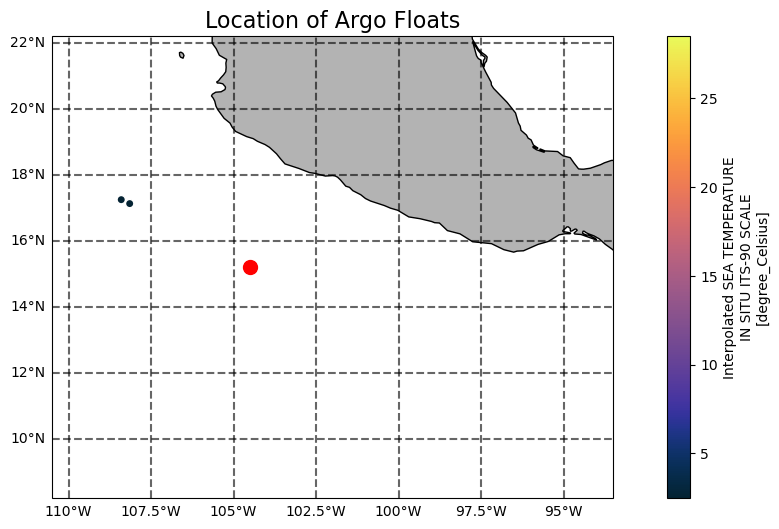

In [101]:
#Plot profile locations

# Figure Attributes
title_size = 16
ax_size = 14

# World Map - where is our data located?
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(14,6))
# Projections
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_ylim(ilat-3,flat+3)
ax.set_xlim(ilon-2,flon+7)
ax.plot(
    hur_center_lon, hur_center_lat,
    marker='o', color='red', markersize=10,
    transform=ccrs.PlateCarree(),
    label="Hurricane Center"
)

# Plot
ds_int.plot.scatter(x='LONGITUDE', y='LATITUDE', hue='TEMP_ADJUSTED', cmap = cmocean.cm.thermal, 
                         transform = ccrs.PlateCarree())


# Coastlines
coast_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.7')
ax.add_feature(coast_50m)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, #x_inline=False, y_inline=False,
                  linewidth=1.5, color='black', alpha=0.6, linestyle='--')
gl.right_labels = False
gl.top_labels = False

plt.title('Location of Argo Floats', size = title_size)
plt.show()

(1000.0, 0.0)

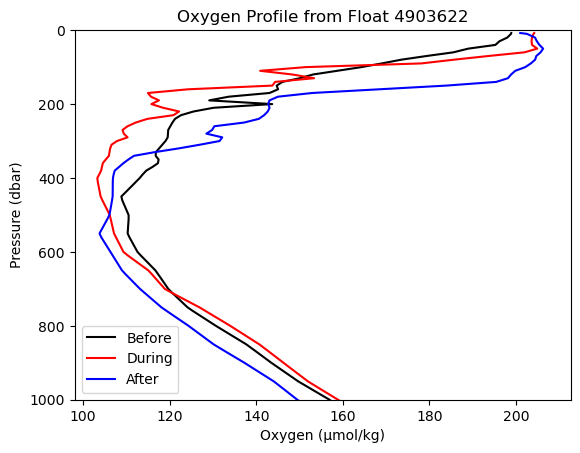

In [80]:
before = 8
during = 9
after = 10

plt.figure()
plt.plot(ds_int['DOXY_ADJUSTED'].sel(N_PROF=before), ds_int['PRES_ADJUSTED'].sel(N_PROF=14), c='black', label = 'Before')
plt.plot(ds_int['DOXY_ADJUSTED'].sel(N_PROF=during), ds_int['PRES_ADJUSTED'].sel(N_PROF=14), c='red', label = 'During')
plt.plot(ds_int['DOXY_ADJUSTED'].sel(N_PROF=after), ds_int['PRES_ADJUSTED'].sel(N_PROF=14), c='blue', label = 'After')
plt.legend()
plt.gca().invert_yaxis()
plt.title("Oxygen Profile from Float "+ str(ds_int['PLATFORM_NUMBER'].sel(N_PROF=14).values))
plt.xlabel('Oxygen (µmol/kg)')
plt.ylabel('Pressure (dbar)')
plt.ylim(1000,0)


# Plot data from one float

In [13]:
ds = xr.open_dataset("/home/jovyan/shared-public/OHW25/ArBu_proj_shared/float/WMO4903625_data.nc")

In [10]:
ds = xr.load_dataset("/home/jovyan/shared-public/OHW25/ArBu_proj_shared/float/WMO4903625_data.nc")
# ds = ds.argo.filter_qc(QC_list=[1, 2, 8], QC_fields=['DOXY_ADJUSTED_QC', 'CHLA_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'], drop=True, mode='all', mask=False)
ds = ds.argo.filter_qc(QC_list=[1, 2, 8], QC_fields=['TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC', 'DOXY_ADJUSTED_QC', 'CHLA_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'], drop=True, mode='all', mask=False)

# # # calculate AOU
# ds['SA'] = sw.conversions.SA_from_SP(ds.PSAL_ADJUSTED, ds.PRES_ADJUSTED, ds.LONGITUDE, ds.LATITUDE)
# ds['CT'] = sw.conversions.CT_from_t(ds.SA, ds.TEMP_ADJUSTED, ds.PRES_ADJUSTED)

# # sw.o2sol returns umol/kg
# ds['DOXY_SAT'] = sw.O2sol(ds.SA , ds.CT, ds.PRES_ADJUSTED, ds.LONGITUDE, ds.LATITUDE)
# ds['AOU'] = (ds.DOXY_SAT - ds.DOXY_ADJUSTED)

# # convert to profiles and then interploate onto regular depth grid
# ds_pr = ds.argo.point2profile()
# ds_int = ds_pr.argo.interp_std_levels(np.arange(0,1010, 10))

/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())
/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


In [15]:
ds = ds.argo.filter_qc(QC_list=[1, 2, 8], QC_fields=['TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC', 'DOXY_ADJUSTED_QC', 'CHLA_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'], drop=True, mode='all', mask=False)
ds_pr = ds.argo.point2profile()

/srv/conda/envs/notebook/lib/python3.12/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


DTypePromotionError: The DType <class 'numpy.dtypes._PyLongDType'> could not be promoted by <class 'numpy.dtypes.StrDType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes._PyLongDType'>, <class 'numpy.dtypes.StrDType'>)

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - 5, lon_max + 5, lat_min - 5, lat_max + 5])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

# Plot hurricane path
ax.plot(lons, lats, 'r-', label=f"{name} path")
ax.scatter(lons, lats, color='red', s=10)

# Plot Argo profiles
ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], color='blue', s=10, label='Argo profiles')

plt.title(f"{name} (2023) Hurricane Path & Argo Profiles")
plt.legend()
output_file = f"hurricane_argo_{name.lower().replace(' ', '_')}.png"
plt.savefig(output_file)
plt.close()
print(f"Map saved to: {output_file}")
